# Mar 11-26, 2024: bayesian sbm 

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import arviz as az
import dill as pickle 

from scipy import sparse, stats, special
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni

from itertools import product, combinations

from IPython.display import Image

import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240615-13:43:27,812 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
RECONST_method = '' #'normal_dist' # f'' f'lds' #f'normal_dist'
if RECONST_method == '':
    GRAPH_type = f'correlation_graph'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}/density-{args.denst}'
    FC_path = f'{ROI_RESULTS_path}/corr_mats'
else: 
    GRAPH_type = f'reconstructed_graph/{RECONST_method}'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}'
    GRAPHS_path = f'{ROI_RESULTS_path}/graphs'

SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group/soft')
PNG_path = f'{ROI_RESULTS_path}/png'
os.system(f'mkdir -p {PNG_path}/group')

# sbm model class
args.dc = ''
args.sbm = 'a' 

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

## individual run estimates

In [5]:
def collect_sbm_fits(args, files):
    def get(name):
        l = [s for s in ssr if name in s]
        return l[0].split('-')[-1] if len(l) > 0 else '0'
    
    fits_df = []
    for file in tqdm(files):
        try:
            ssr = file.split('/')[-2].split('_')
            sub, ses, run = list(map(get, ['sub', 'ses', 'run']))
            
            with open(f'{file}', 'rb') as f:
                all_vars = pickle.load(f)
                if len(all_vars) == 7:
                    [g, L, pmode, modes, marginals, state, Bes] = all_vars
                    converged = False
                elif len(all_vars) == 8:
                    [g, L, pmode, modes, marginals, state, Bes, converged] = all_vars
            
            df = pd.DataFrame({
                'sub':[int(sub[-2:])],
                'ses':[int(ses)],
                'run':[int(run)],
                'ssr':[ssr],
                'graph':[g],
                'sbm':[f'sbm-{args.dc}-{args.sbm}'],
                'evidence':[L],
                'state':[state],
                'pmode':[pmode],
                'modes':[modes],
                'marginals':[marginals],
                'Be':[Bes],
                'converged':[converged],
                'file':[file],
            })
            
            fits_df.append(df)
        except:
            pass
        
    fits_df = pd.concat(fits_df)
    fits_df = fits_df.sort_values(
        by=['sub', 'ses', 'run']
    ).reset_index(drop=True)

    return fits_df

In [6]:
files = sorted(glob.glob(f'{SBM_path}/*/sbm-{args.dc}-{args.sbm}*'))
fits_df = collect_sbm_fits(args, files)
fits_df.head(n=1)

100%|██████████| 24/24 [02:59<00:00,  7.48s/it]


,sub,ses,run,ssr,graph,sbm,evidence,state,pmode,modes,marginals,Be,converged,file
0,1,2,0,"[sub-SLC01, ses-2]","<Graph object, undirected, with 162 vertices a...",sbm--a,-7064.143682,"<PPBlockState object with 4 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,"[[[1.0, 0.0, 0.0, 0.0], [0.0, 0.001, 0.999, 0....","[3.9060911121489754, 3.889497448150956, 3.8776...",True,/home/govindas/mouse_dataset/roi_results/type-...


23it [37:51, 98.78s/it] 


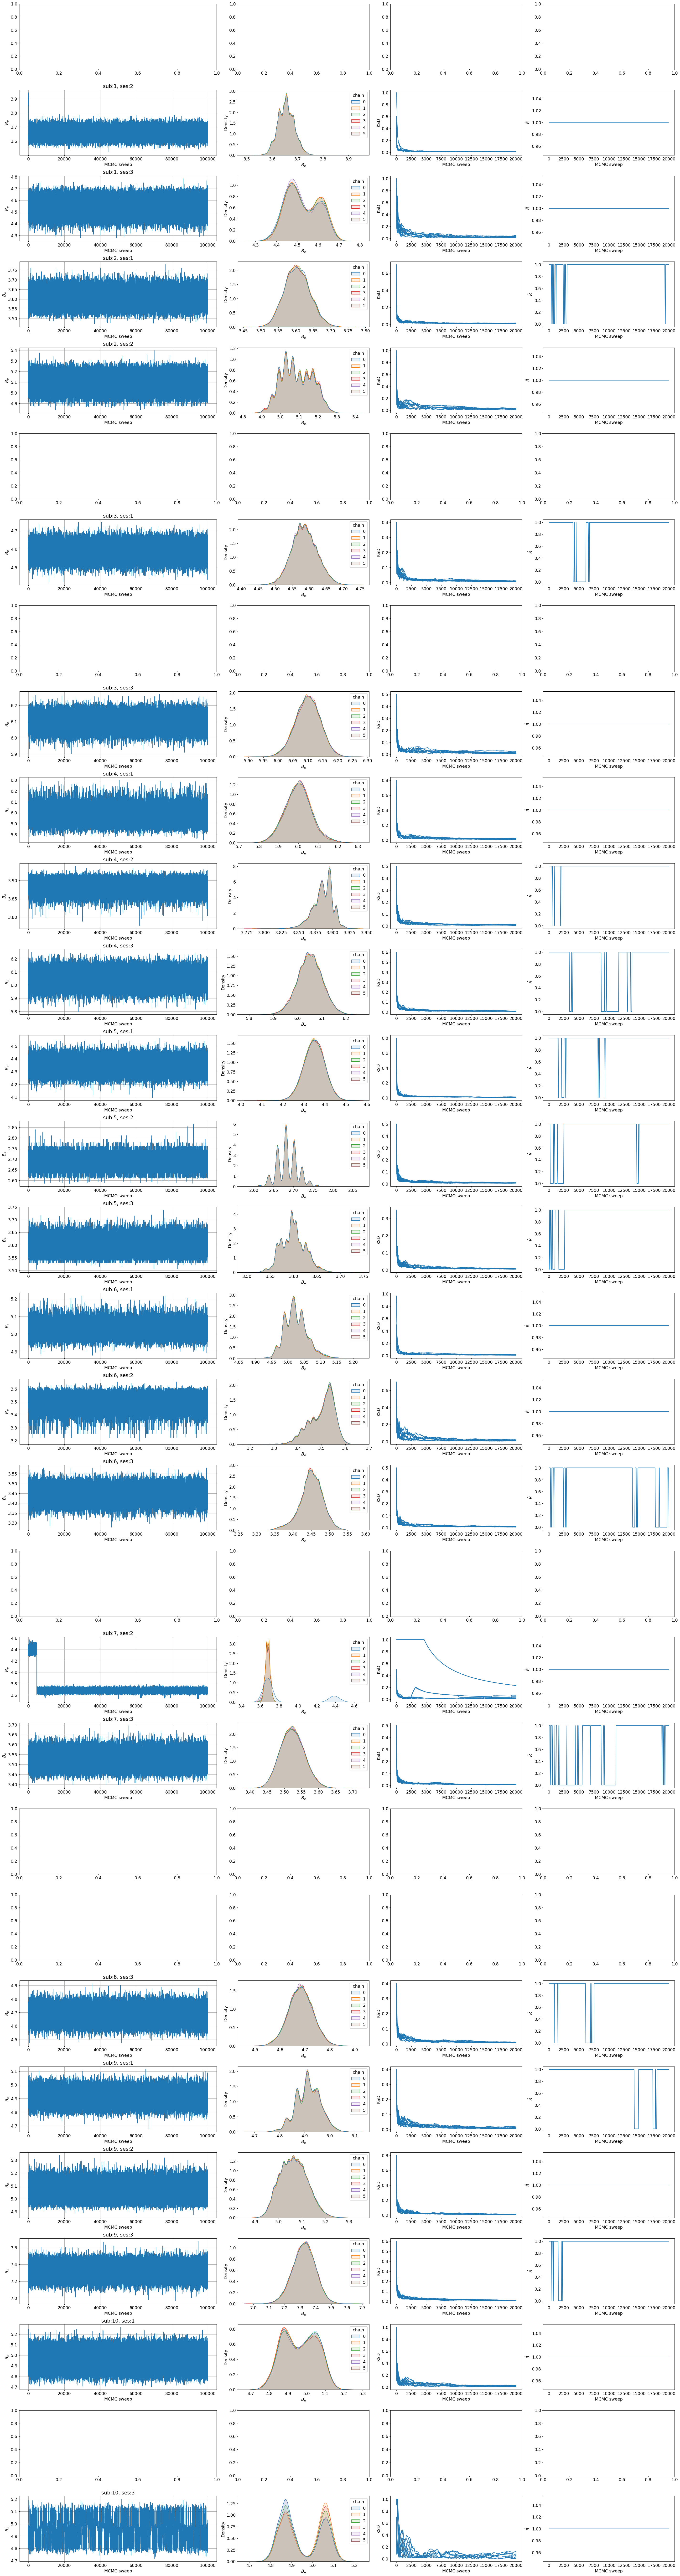

In [7]:
# histograms/ probability densities of `Be`
def prob_density(chain, win_len=2000):
    chain_idxs = []
    for idx_win in range(np.ceil(len(chain)/win_len).astype(int)):
        chain_idxs += [idx_win]*len(chain[idx_win*win_len : (idx_win+1)*win_len])

    win_df = pd.DataFrame({
        'Be':chain,
        'chain':chain_idxs,
    })
    return win_df

def KS_distances(args, win_df):
    chain_idxs = win_df['chain'].unique()
    ksd_dfs = []
    for idx1, idx2 in (combinations(chain_idxs, 2)):
        Ds = []
        for t in range(10, args.win_len, 10):
            Bes_chain1 = win_df[win_df['chain'] == idx1]['Be'][:t]
            Bes_chain2 = win_df[win_df['chain'] == idx2]['Be'][:t]
            res = stats.ks_2samp(Bes_chain1, Bes_chain2)
            Ds.append(res.statistic)
        df = pd.DataFrame({
            'ch1': [idx1] * len(Ds),
            'ch2': [idx2] * len(Ds),
            't': np.arange(10, args.win_len, 10),
            'D': Ds,
        })
        ksd_dfs.append(df)
    ksd_dfs = pd.concat(ksd_dfs)    
    return ksd_dfs

def plot_KSD(args, win_df, ksd_dfs, ax):
    chain_idxs = win_df['chain'].unique()[:-1]
    for idx1, idx2 in combinations(chain_idxs, 2):
        t_D = ksd_dfs[
            (ksd_dfs['ch1'] == idx1) &
            (ksd_dfs['ch2'] == idx2)
        ][['t', 'D']].to_numpy()
        ax.plot(t_D[:, 0], t_D[:, 1], c='tab:blue')
    return None

def Rhat(args, win_df):
    idx_chains = win_df['chain'].unique()[:-1]
    chains = []
    for idx in idx_chains:
        chains += [win_df[win_df['chain'] == idx]['Be'].to_numpy()]
    chains = np.stack(chains, axis=0)
    
    ts = np.arange(50, chains.shape[-1], 50)
    rhats = np.zeros_like(ts)
    for i, t in enumerate(ts): 
        rhats[i] = az.rhat(chains[:, :t])
    
    return ts, rhats

figfile = f'{PNG_path}/group/sbm-{args.dc}-{args.sbm}_desc-diagnosis.png'
if os.path.exists(figfile):
    display(Image(figfile))
else:
    ncols = 4
    nrows = 30
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols+3.5, 4*nrows), width_ratios=[1.5, 1, 1, 1], dpi=90, sharex=False, sharey=False)
    fig.tight_layout(h_pad=3, w_pad=2.2)

    for _, row in tqdm(fits_df.iterrows()):
        sub, ses = row[['sub', 'ses']]
        Bes = row['Be'] if not 'h' in args.sbm else row['Be'][0]
        args.win_len = len(Bes) // 5
        
        idx = 3 * (sub - 1) + (ses - 1)
        ax = axs[idx, 0]
        ax.plot(Bes)
        ax.grid(True)
        ax.set(title=f'sub:{sub}, ses:{ses}', ylabel=f'$B_e$', xlabel=f'MCMC sweep')
        
        ax = axs[idx, 1]    
        win_df = prob_density(Bes, win_len=args.win_len)
        sns.kdeplot(data=win_df, x='Be', hue='chain', palette='tab10', fill=True, alpha=0.1, ax=ax)
        ax.set(xlabel=f'$B_e$', ylabel=f'Density')
        
        ax = axs[idx, 2]
        ksd_dfs = KS_distances(args, win_df)
        plot_KSD(args, win_df, ksd_dfs, ax)
        ax.set(xlabel=f'MCMC sweep', ylabel=f'KSD')
        
        ax = axs[idx, 3]
        ts, rhats = Rhat(args, win_df)
        ax.plot(ts, rhats)
        ax.set(xlabel=f'MCMC sweep', ylabel='$\hat{R}$')
        
    fig.savefig(figfile)